In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
# Load the data
file_path = "/Users/sherahuang/Documents/Kaggle/AMP-PD-prediction/data/"
peptides_df = pd.read_csv(f'{file_path}train_peptides.csv')
proteins_df = pd.read_csv(f'{file_path}train_proteins.csv')
clinical_df = pd.read_csv(f'{file_path}train_clinical_data.csv')

In [9]:
pep_merged = peptides_df.merge(clinical_df, on=['visit_id', 'visit_month', 'patient_id'])
prot_merged = proteins_df.merge(clinical_df, on=['visit_id', 'visit_month', 'patient_id'])


In [52]:
import pandas as pd

pep_merged.to_csv('pep_merged.csv', index=False)
prot_merged.to_csv('prot_merged.csv', index=False)

In [10]:
prot_merged

,visit_id,visit_month,patient_id,UniProt,NPX,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,0,55,O00391,11254.3,10.0,6.0,15.0,NaN,NaN
1,55_0,0,55,O00533,732430.0,10.0,6.0,15.0,NaN,NaN
2,55_0,0,55,O00584,39585.8,10.0,6.0,15.0,NaN,NaN
3,55_0,0,55,O14498,41526.9,10.0,6.0,15.0,NaN,NaN
4,55_0,0,55,O14773,31238.0,10.0,6.0,15.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
223263,58648_108,108,58648,Q9UBX5,27387.8,6.0,0.0,0.0,NaN,NaN
223264,58648_108,108,58648,Q9UHG2,369437.0,6.0,0.0,0.0,NaN,NaN
223265,58648_108,108,58648,Q9UKV8,105830.0,6.0,0.0,0.0,NaN,NaN
223266,58648_108,108,58648,Q9Y646,21257.6,6.0,0.0,0.0,NaN,NaN


# LSTM

In [47]:
!pip install tensorflow keras

  Using cached tensorflow-2.12.0-cp39-cp39-macosx_10_15_x86_64.whl (230.1 MB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)


In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow import keras


# Extract the relevant columns
X = prot_merged[['UniProt', 'NPX']].values
y = prot_merged['updrs_1'].values

# Scale the input data
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Reshape the input data for LSTM
look_back = 1
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Evaluate the model
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, np.sqrt(train_score)))
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, np.sqrt(test_score)))

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert the scaling of the predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate the root mean squared error
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test)**2))
print('Train RMSE: {:.2f}'.format(train_rmse))
print('Test RMSE: {:.2f}'.format(test_rmse))


TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [51]:
!pip install tensorflow==2.7.0
!pip install --upgrade tensorflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Select the features and target variable
X = prot_merged[['patient_id', 'visit_month', 'NPX']].values
y = prot_merged['updrs_1'].values

# Scale the input variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_scaled.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape the input data to fit the LSTM model
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Train the LSTM model
model.fit(X_reshaped, y, epochs=100, batch_size=32, verbose=2)

# Make predictions on new data
new_data = np.array([[55, 0, 11254.3], [55, 1, 12345.6], [56, 0, 9876.5]])
new_data_scaled = scaler.transform(new_data)
new_data_reshaped = new_data_scaled.reshape(new_data_scaled.shape[0], new_data_scaled.shape[1], 1)
predictions = model.predict(new_data_reshaped)

# Print the predictions
print(predictions)


     |████████████████████████████████| 207.1 MB 31 kB/s  eta 0:00:011
     |████████████████████████████████| 463 kB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.9 MB/s  eta 0:00:01
     |████████████████████████████████| 1.3 MB 32.0 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.0
    Uninstalling tensorflow-2.12.0:
      Successfully uninstalled tensorflow-2.12.0
  Using cached 

  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0


TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [11]:
import pandas as pd

#std_by_protein = prot_merged.groupby('UniProt')['NPX'].std()

#print(std_by_protein)

for protein in prot_merged['UniProt'].unique():
    protein_data = prot_merged.loc[prot_merged['UniProt'] == protein, 'NPX']
    print(f"Statistical summary for {protein}:")
    print(protein_data.describe())


Statistical summary for O00391:
count      736.000000
mean     11605.680568
std       2815.680292
min        873.778000
25%       9722.882500
50%      11482.250000
75%      13371.075000
max      21361.800000
Name: NPX, dtype: float64
Statistical summary for O00533:
count    1.067000e+03
mean     5.092013e+05
std      2.336834e+05
min      5.971820e+04
25%      3.460445e+05
50%      4.817440e+05
75%      6.447260e+05
max      1.806980e+06
Name: NPX, dtype: float64
Statistical summary for O00584:
count     1055.000000
mean     26488.189128
std      10692.457986
min       1300.920000
25%      20043.100000
50%      26510.000000
75%      33129.900000
max      66252.400000
Name: NPX, dtype: float64
Statistical summary for O14498:
count      989.000000
mean     27323.052376
std       8477.112143
min       8945.340000
25%      21125.100000
50%      26621.800000
75%      32506.000000
max      65347.900000
Name: NPX, dtype: float64
Statistical summary for O14773:
count     1004.000000
mean     1

Statistical summary for P01859:
count    1.066000e+03
mean     2.147875e+06
std      9.885502e+05
min      4.353200e+04
25%      1.426878e+06
50%      2.055470e+06
75%      2.660635e+06
max      7.487250e+06
Name: NPX, dtype: float64
Statistical summary for P01860:
count    1.062000e+03
mean     5.380067e+05
std      3.325858e+05
min      4.742050e+03
25%      3.107995e+05
50%      4.700485e+05
75%      6.976725e+05
max      2.413250e+06
Name: NPX, dtype: float64
Statistical summary for P01861:
count       797.000000
mean      77845.578651
std       58573.526961
min         707.405000
25%       36502.600000
50%       65004.700000
75%       99879.500000
max      480082.000000
Name: NPX, dtype: float64
Statistical summary for P01876:
count    1.068000e+03
mean     2.608209e+06
std      1.587123e+06
min      3.502330e+04
25%      1.747592e+06
50%      2.373640e+06
75%      3.188742e+06
max      3.529560e+07
Name: NPX, dtype: float64
Statistical summary for P01877:
count      1000.000000
m

Statistical summary for P05067:
count    1.067000e+03
mean     8.637900e+05
std      3.166208e+05
min      1.721000e+05
25%      6.305160e+05
50%      8.277480e+05
75%      1.063260e+06
max      2.622140e+06
Name: NPX, dtype: float64
Statistical summary for P05090:
count    1.068000e+03
mean     5.555330e+06
std      1.461694e+06
min      1.576970e+05
25%      4.566675e+06
50%      5.393410e+06
75%      6.406310e+06
max      1.159060e+07
Name: NPX, dtype: float64
Statistical summary for P05155:
count    1.067000e+03
mean     8.815209e+05
std      2.278054e+05
min      3.874340e+04
25%      7.470485e+05
50%      8.750350e+05
75%      1.016980e+06
max      1.766540e+06
Name: NPX, dtype: float64
Statistical summary for P05156:
count      1067.000000
mean      82893.039082
std       26976.232773
min       11398.100000
25%       70437.900000
50%       85513.600000
75%      100341.500000
max      186670.000000
Name: NPX, dtype: float64
Statistical summary for P05408:
count      681.000000
me

Statistical summary for P13611:
count      978.000000
mean     22501.250665
std       9312.306927
min       2095.890000
25%      16632.325000
50%      23040.000000
75%      28528.750000
max      53024.600000
Name: NPX, dtype: float64
Statistical summary for P13671:
count      821.000000
mean      8562.590767
std       1960.992009
min       3415.860000
25%       7258.990000
50%       8531.360000
75%       9699.740000
max      15160.000000
Name: NPX, dtype: float64
Statistical summary for P13987:
count    1.067000e+03
mean     3.894525e+05
std      1.321714e+05
min      1.058190e+05
25%      2.935840e+05
50%      3.772460e+05
75%      4.672890e+05
max      1.056250e+06
Name: NPX, dtype: float64
Statistical summary for P14174:
count      993.000000
mean     25909.409658
std       9216.141914
min       5495.370000
25%      19200.900000
50%      24717.200000
75%      31092.000000
max      67216.500000
Name: NPX, dtype: float64
Statistical summary for P14314:
count      909.000000
mean     2

Statistical summary for P55290:
count      1046.000000
mean      32593.644503
std       17027.511305
min        1865.760000
25%       20759.125000
50%       32315.500000
75%       43320.750000
max      111203.000000
Name: NPX, dtype: float64
Statistical summary for P61278:
count      978.000000
mean      6060.862706
std       3588.612125
min        455.415000
25%       3495.557500
50%       5456.835000
75%       7713.672500
max      25696.100000
Name: NPX, dtype: float64
Statistical summary for P61626:
count     1011.000000
mean     14575.771222
std       6170.872321
min        487.396000
25%      10449.350000
50%      13727.200000
75%      17678.550000
max      53361.000000
Name: NPX, dtype: float64
Statistical summary for P61769:
count    1.064000e+03
mean     3.181165e+05
std      1.418687e+05
min      8.327450e+03
25%      2.190995e+05
50%      3.081385e+05
75%      3.906135e+05
max      1.046130e+06
Name: NPX, dtype: float64
Statistical summary for P61916:
count      1067.000000
m

Statistical summary for Q99674:
count      884.000000
mean     22394.696391
std       9190.416771
min       5584.240000
25%      15728.625000
50%      21262.250000
75%      27797.825000
max      63979.400000
Name: NPX, dtype: float64
Statistical summary for Q99832:
count       586.000000
mean      42172.433294
std       13635.549186
min        7850.010000
25%       32633.275000
50%       40261.600000
75%       50717.925000
max      117267.000000
Name: NPX, dtype: float64
Statistical summary for Q99969:
count      956.000000
mean     12805.383159
std       4269.699453
min        641.390000
25%       9861.515000
50%      12304.250000
75%      15256.850000
max      32915.500000
Name: NPX, dtype: float64
Statistical summary for Q9BY67:
count     1006.000000
mean     27003.842435
std       9285.711202
min       6396.840000
25%      20416.050000
50%      26187.350000
75%      32806.825000
max      62427.800000
Name: NPX, dtype: float64
Statistical summary for Q9HDC9:
count       915.000000
m

In [39]:
prot_merged['NPX'].isna().sum()

0

In [33]:
import pandas as pd

std_by_protein = prot_merged.groupby(['patient_id', 'UniProt'])['NPX'].std()
mean_by_protein= prot_merged.groupby(['patient_id', 'UniProt'])['NPX'].mean()
x2 = std_by_protein / mean_by_protein
sorted_prot = x2.sort_values()
mask = sorted_prot < 0.2
print(sorted_prot[mask])

mask.sum()


patient_id  UniProt
27607       P60174     0.000005
41617       P39060     0.000054
7151        P04196     0.000123
10718       O14791     0.000165
51893       Q99969     0.000196
                         ...   
27872       P60174     0.199959
27893       P00747     0.199978
59550       Q16610     0.199979
58270       P08253     0.199989
27607       P02647     0.199993
Name: NPX, Length: 32402, dtype: float64


32402

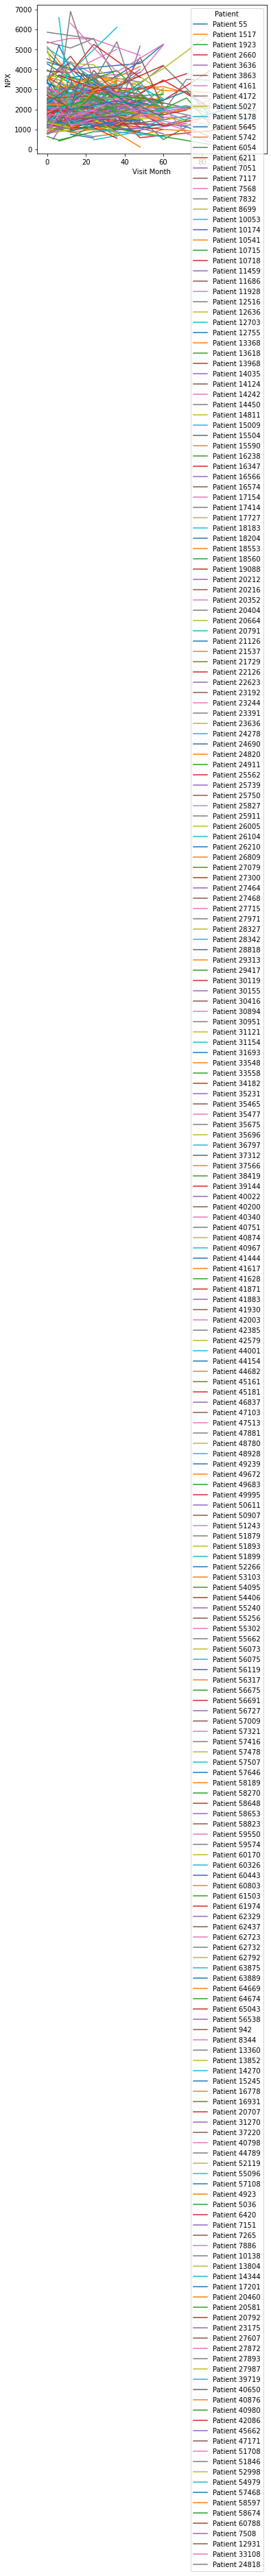

In [16]:
import matplotlib.pyplot as plt

# Define the protein of interest
protein = 'Q99435'

# Loop through each patient and create a time series plot for the protein
for patient in prot_merged['patient_id'].unique():
    # Subset the data to the protein of interest and the current patient
    subset = prot_merged[(prot_merged['UniProt'] == protein) & (prot_merged['patient_id'] == patient)]
    
    # Create the time series plot
    plt.plot(subset['visit_month'], subset['NPX'], label=f'Patient {patient}')
    
# Add axis labels and legend
plt.xlabel('Visit Month')
plt.ylabel('NPX')
plt.legend(title='Patient')
plt.show()


# Deep learning - LSTM (long short-term memory networks)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define the model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Preprocess the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train the model
model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {accuracy}")


/var/folders/1m/qlgvd1tj4zj_xvwlsjfgf8g40000gn/T/ipykernel_16099/2349492479.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  protein_data.loc[(patient_id, protein), 'NPX'].plot()


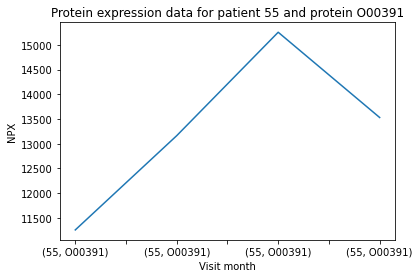

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the visit_month column to a datetime format
pro_merged['visit_month'] = pd.to_datetime(pro_merged['visit_month'], format='%Y-%m')

# Set the patient_id and UniProt columns as the index
pro_merged.set_index(['visit_id'], inplace=True)

# Plot the time series graph for the protein expression data of a specific patient and protein
patient_id = 55
protein = 'Q99435'
protein_data.loc[(patient_id, protein), 'NPX'].plot()
plt.title(f"Protein expression data for patient {patient_id} and protein {protein}")
plt.xlabel('Visit month')
plt.ylabel('NPX')
plt.show()


In [4]:
peptides_df

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,202820.00
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,105830.00
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,21257.60
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [5]:
clinical_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


In [41]:
col_encode_peptides = ['UniProt', 'Peptide']
peptides_df_encoded = pd.get_dummies(peptides_df, columns=col_encode_peptides)

In [42]:
col_encode_proteins = ['UniProt']
proteins_df_encoded = pd.get_dummies(proteins_df, columns=col_encode_proteins)

In [43]:
col_encode_clinical = ['upd23b_clinical_state_on_medication']
clinical_df_encoded = pd.get_dummies(clinical_df, columns=col_encode_clinical)

In [35]:
clinical_df_encoded['updrs_1'].isna().sum()

1

In [44]:
from sklearn.impute import SimpleImputer

# create an instance of the SimpleImputer class with strategy='median'
imputer = SimpleImputer(strategy='median')

# fit the imputer to the training data
imputer.fit(clinical_df_encoded[['updrs_1']])
imputer.fit(clinical_df_encoded[['updrs_2']])
imputer.fit(clinical_df_encoded[['updrs_3']])
imputer.fit(clinical_df_encoded[['updrs_4']])

# impute the missing values in the training and test data
clinical_df_encoded['updrs_1'] = imputer.transform(clinical_df_encoded[['updrs_1']])
clinical_df_encoded['updrs_2'] = imputer.transform(clinical_df_encoded[['updrs_2']])
clinical_df_encoded['updrs_3'] = imputer.transform(clinical_df_encoded[['updrs_3']])
clinical_df_encoded['updrs_4'] = imputer.transform(clinical_df_encoded[['updrs_4']])

/Users/sherahuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- updrs_1
Feature names seen at fit time, yet now missing:
- updrs_4

  warnings.warn(message, FutureWarning)
/Users/sherahuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- updrs_2
Feature names seen at fit time, yet now missing:
- updrs_4

  warnings.warn(message, FutureWarning)
/Users/sherahuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- updrs_3
Feature names seen at fit time, yet now m

In [ ]:
merged_df = peptides_df_encoded.merge(proteins_df_encoded, on=['visit_id', 'visit_month', 'patient_id'])
merged_df = merged_df.merge(clinical_df_encoded, on=['visit_id', 'visit_month', 'patient_id'])


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define the model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(merged_df.shape[1], merged_df.shape[2])))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Preprocess the data
scaler = StandardScaler()
merged_df = scaler.fit_transform(merged_df.reshape(-1, X_train.shape[-1])).reshape(merged_df.shape)
#X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

le = LabelEncoder()
#y_train_encoded = le.fit_transform(y_train)
#y_test_encoded = le.transform(y_test)

# Train the model
#model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
#loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {accuracy}")


In [1]:
import pandas as pd

peptides = pd.read_csv('train_peptides.csv')
proteins = pd.read_csv('train_proteins.csv')
clinical_data = pd.read_csv('train_clinical_data.csv')

data = pd.merge(peptides, proteins, on=['visit_id', 'visit_month', 'patient_id', 'UniProt'], how='left')
data = pd.merge(data, clinical_data, on=['visit_id', 'visit_month', 'patient_id'], how='left')


In [3]:
print(data.isna())

        visit_id  visit_month  patient_id  UniProt  Peptide  PeptideAbundance  \
0          False        False       False    False    False             False   
1          False        False       False    False    False             False   
2          False        False       False    False    False             False   
3          False        False       False    False    False             False   
4          False        False       False    False    False             False   
...          ...          ...         ...      ...      ...               ...   
981829     False        False       False    False    False             False   
981830     False        False       False    False    False             False   
981831     False        False       False    False    False             False   
981832     False        False       False    False    False             False   
981833     False        False       False    False    False             False   

          NPX  updrs_1  upd

In [9]:
import pandas as pd

# One-hot encode the upd23b_clinical_state_on_medication column
one_hot = pd.get_dummies(data['upd23b_clinical_state_on_medication'])

# Drop the original column from the DataFrame
df = data.drop('upd23b_clinical_state_on_medication', axis=1)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df, one_hot], axis=1)

# Print the updated DataFrame
print(df.head())


  visit_id  visit_month  patient_id UniProt  \
0     55_0            0          55  O00391   
1     55_0            0          55  O00533   
2     55_0            0          55  O00533   
3     55_0            0          55  O00533   
4     55_0            0          55  O00533   

                                  Peptide  PeptideAbundance       NPX  \
0                           NEQEQPLGQWHLS           11254.3   11254.3   
1                             GNPEPTFSWTK          102060.0  732430.0   
2                         IEIPSSVQQVPTIIK          174185.0  732430.0   
3  KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK           27278.9  732430.0   
4                            SMEQNGPGLEYR           30838.7  732430.0   

   updrs_1  updrs_2  updrs_3  updrs_4  Off  On  
0     10.0      6.0     15.0      NaN    0   0  
1     10.0      6.0     15.0      NaN    0   0  
2     10.0      6.0     15.0      NaN    0   0  
3     10.0      6.0     15.0      NaN    0   0  
4     10.0      6.0     15.0     

In [4]:
# Replace missing values with the mean of neighboring values
data1 = data.fillna(method='ffill', inplace=True)